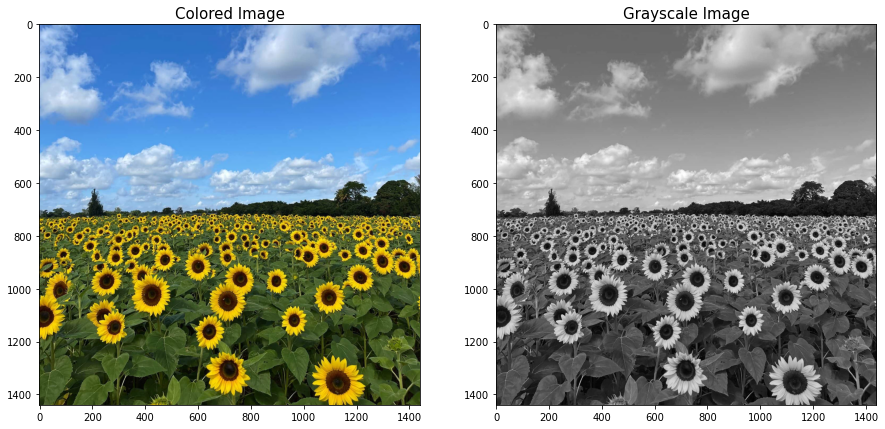

In [12]:
import numpy as np
from skimage.io import imshow, imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

sample = imread('./the_berry_farms_sunflower_field.jpeg')
sample_g = rgb2gray(sample)
fig, ax = plt.subplots(1,2,figsize=(15,10))
ax[0].imshow(sample)
ax[1].imshow(sample_g,cmap='gray')
ax[0].set_title('Colored Image',fontsize=15)
ax[1].set_title('Grayscale Image',fontsize=15)
plt.show()

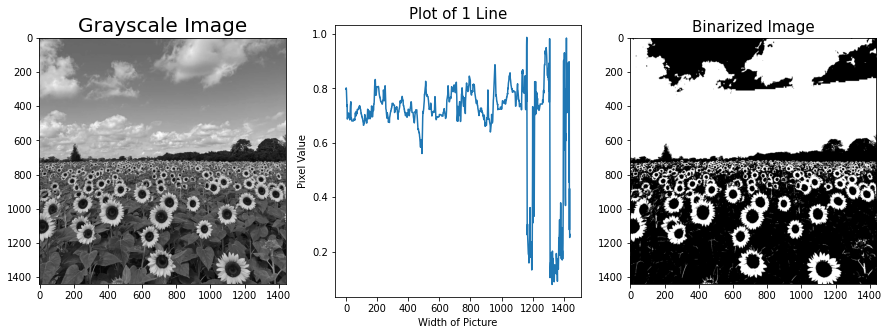

In [13]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
sample_b = sample_g > 0.5
ax[0].set_title('Grayscale Image',fontsize=20)
ax[0].imshow(sample_g,cmap='gray')
ax[1].plot(sample_g[600])
ax[1].set_ylabel('Pixel Value')
ax[1].set_xlabel('Width of Picture')
ax[1].set_title('Plot of 1 Line',fontsize=15)
ax[2].set_title('Binarized Image',fontsize=15)
ax[2].imshow(sample_b,cmap='gray')

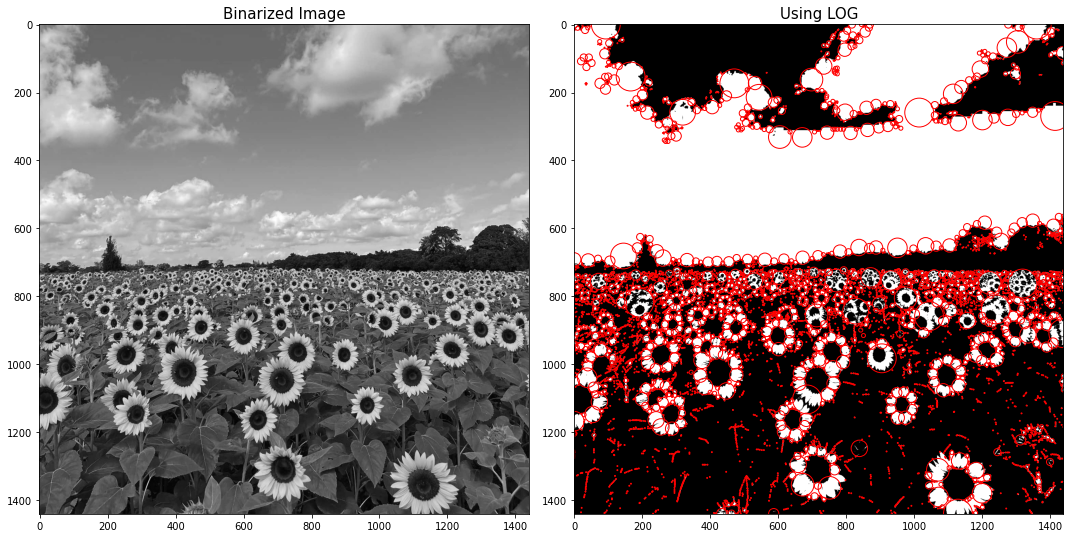

In [17]:
from skimage.feature import blob_dog, blob_log, blob_doh
fig, ax = plt.subplots(1,2,figsize=(15,10))
ax[0].set_title('Binarized Image',fontsize=15)
ax[0].imshow(sample_g,cmap='gray')
blobs = blob_log(sample_b, max_sigma=30, threshold=0.01)
ax[1].imshow(sample_b, cmap='gray')
for blob in blobs:
    y, x, area = blob
    ax[1].add_patch(plt.Circle((x, y), area*np.sqrt(2), color='r', 
                            fill=False))
ax[1].set_title('Using LOG',fontsize=15)
plt.tight_layout()
plt.show() 

Largest Circle Parameters - Center: (471.0, 173.0), Radius: 30.0


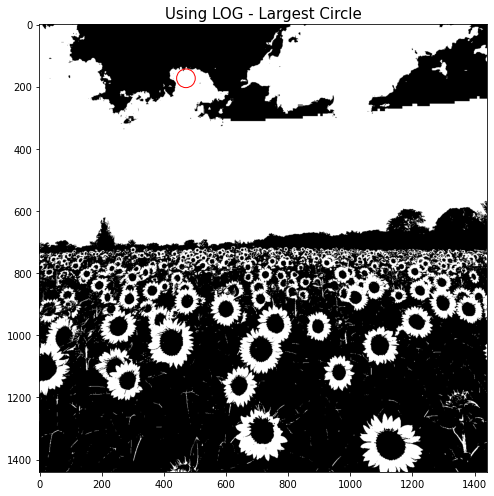

In [22]:
if len(blobs) > 0:
    largest_blob = max(blobs, key=lambda x: x[2])  # The third value in each blob tuple is the area
    y, x, radius = largest_blob

    # Print the parameters of the largest circle
    print(f"Largest Circle Parameters - Center: ({x}, {y}), Radius: {radius}")

    # Plot the image and draw the largest circle
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.imshow(sample_b, cmap='gray')
    ax.add_patch(plt.Circle((x, y), radius, color='r', fill=False))
    ax.set_title('Using LOG - Largest Circle', fontsize=15)
    plt.tight_layout()
    plt.show()
else:
    print("No blobs (circles) were detected in the image.")

# Question 2

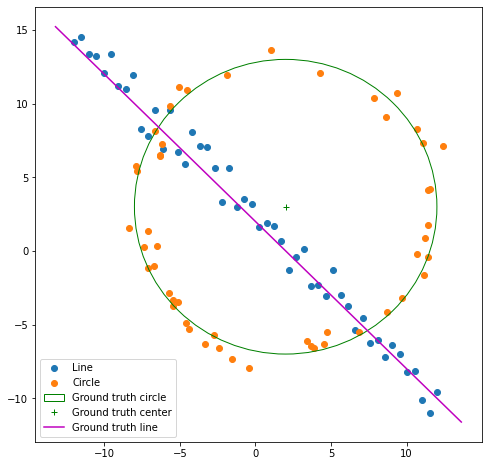

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b0 = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b0 + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+g', label='Ground truth center')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b0
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

plt.show()


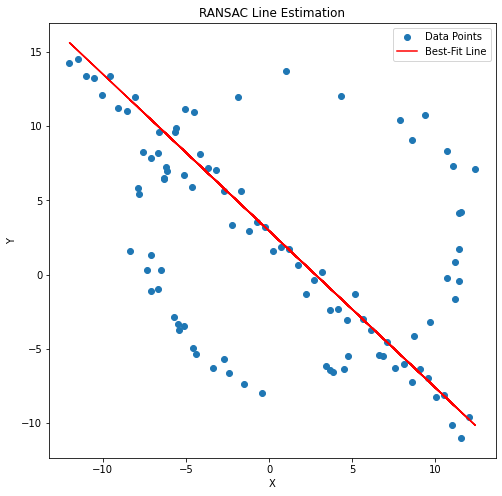

Estimated Line Parameters: a=0.73, b=0.69, d=2.02


In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Define RANSAC parameters
max_iterations = True  # Maximum number of iterations
inlier_threshold = 1 # Threshold for inliers (adjust as needed)
min_inliers = 30 # Minimum number of inliers required to fit a model

# Function to estimate the line parameters [a, b]
def estimate_line(points):
    x1, y1, x2, y2 = points[0, 0], points[0, 1], points[1, 0], points[1, 1]
    a = y2 - y1
    b = x1 - x2
    norm = np.sqrt(a ** 2 + b ** 2)
    a /= norm
    b /= norm
    d = np.abs(x1 * a + y1 * b)  # Perpendicular distance from origin
    return a, b, d

# Function to calculate the error (normal distance to the line)
def line_error(params, points):
    a, b, d = params
    distances = np.abs(points[:, 0] * a + points[:, 1] * b - d)
    return distances


# RANSAC algorithm for line estimation
best_line = None
best_inliers_line = 0

for _ in range(max_iterations):
    # Randomly select two points
    random_indices = np.random.choice(len(X), 2, replace=False)
    random_points = X[random_indices]

    # Estimate the line parameters [a, b, d]
    a, b, d = estimate_line(random_points)

    # Calculate the error (normal distance to the line)
    errors = line_error([a, b, d], X)

    # Count inliers (points that are within the threshold)
    inliers = np.sum(errors < inlier_threshold)

    if inliers >= min_inliers and inliers > best_inliers_line:
        best_line = [a, b, d]
        best_inliers_line = inliers

# Plot the data and the estimated line
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], label='Data Points')
plt.plot(X[:, 0], (-X[:, 0] * best_line[0])/ best_line[1] + best_line[2] / best_line[1], 'r', label='Best-Fit Line')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('RANSAC Line Estimation')
plt.show()

# Print the estimated line parameters
print(f'Estimated Line Parameters: a={best_line[0]:.2f}, b={best_line[1]:.2f}, d={best_line[2]:.2f}')

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Subtract the consensus of the best line (remnant)
line_inliers = X[errors < inlier_threshold]
X_remnant = X[errors >= inlier_threshold]
